# Are reviews autocorrelated?

In in my [previous notebook](https://github.com/nolanbconaway/pitchfork-data/blob/master/notebooks/best-new-music-iid.ipynb), I evaluated whether best new music reviews occur independently of one another. I did not end up discovering anything to suggest otherwise: the number of best new music reviews per day was nicely explained by a binomial sampling model, and the probability of getting a best new music review did not change depending on whether there was a best new music the day before (or two days before, etc).

But in that notebook I didn't account for individual *authors*. The authors are ostensibly the ones who apply scores and the best new music label, right? So let's rephrase the question: are reviews from each author autocorrelated? If an author applies the best new music label to an album, does that change the probability the next album will be best new music? If an author gives an especially low score to an album, will they look more favorably upon the next one?

We know from lots of studies (like [this one](https://academic.oup.com/qje/article/131/3/1181/2590011/)) that decisions in other domains (e.g., baseball umpires calling stikes/balls) tend to affect one another, so it's plausible we can find similar patterns in this dataset.

In [1]:
import sqlite3, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import savgol_filter

pd.set_option('precision', 2)
np.set_printoptions(precision=2)

con = sqlite3.connect('../pitchfork.db')
all_reviews = pd.read_sql('SELECT * FROM reviews WHERE pub_year < 2017', con)
con.close()

## Cleaning...

As in the previous notebook, I'm going to remove reviews from before the advent of the best new music label.

In [2]:
# convert pub_date to datetime object, get unix timestamps
reviews = all_reviews.copy(deep = True) # slice to new object
reviews['pub_date'] = pd.to_datetime(reviews.pub_date, format = '%Y-%m-%d')
reviews['unix_time'] = reviews.pub_date.astype(np.int64, copy = True) // 10**9

# find the first best new music, get rid of everything before it
first_bnm = reviews.loc[reviews.best_new_music == True, 'unix_time'].min()
reviews = reviews.loc[reviews.unix_time >= first_bnm]

# print out date of first bnm
idx = (reviews.unix_time == first_bnm) & (reviews.best_new_music == True)
first_bnm_str = datetime.datetime.fromtimestamp(first_bnm)
print('First best new music: ' + first_bnm_str.strftime('%B %d, %Y'))

# find overall proportion of best new music
proportion_bnm = np.mean(reviews.best_new_music)
print('Global p(bnm): ' + str(proportion_bnm))

First best new music: January 14, 2003
Global p(bnm): 0.0573885466854


## How far apart do reviews tend to be?

The strength of an autocorrelation likely depends on the frequency and interval between events. I'm just guessing, but probably autocorrelations are stronger when the events occur in close temporal succession. In [this notebook](https://github.com/nolanbconaway/pitchfork-data/blob/master/notebooks/reviewer-development.ipynb) I observed that there is a huge range in the number of reviews written by individual authors (from 1 to well over 200), but I haven't looked into the span of time between individual reviews.

In [3]:
# add columns for the author's review count, time since last review
reviews['review_num'] = pd.Series(index = reviews.index)
reviews['days_elapsed'] = pd.Series(index = reviews.index)

for a, rows in reviews.copy().groupby('author'):
    rows_sort = rows.sort_values(by = 'unix_time')
    
    # add review number
    nums = np.arange(rows.shape[0], dtype = int)
    reviews.loc[rows_sort.index, 'review_num'] = nums
    
    # add days elapsed
    days_elapsed = np.zeros(nums.shape) -1
    for j in nums[1:]:
        curr = rows_sort.iloc[j]
        prev = rows_sort.iloc[j-1]
        seconds_elapsed = curr.unix_time - prev.unix_time
        days_elapsed[j] = seconds_elapsed / 86400.0
        
    days_elapsed[days_elapsed<0] = np.NAN
    reviews.loc[rows_sort.index, 'days_elapsed'] = days_elapsed            

reviews.days_elapsed.describe()

count    16024.00
mean        18.64
std         73.09
min          0.00
25%          3.00
50%          7.00
75%         16.00
max       3550.00
Name: days_elapsed, dtype: float64

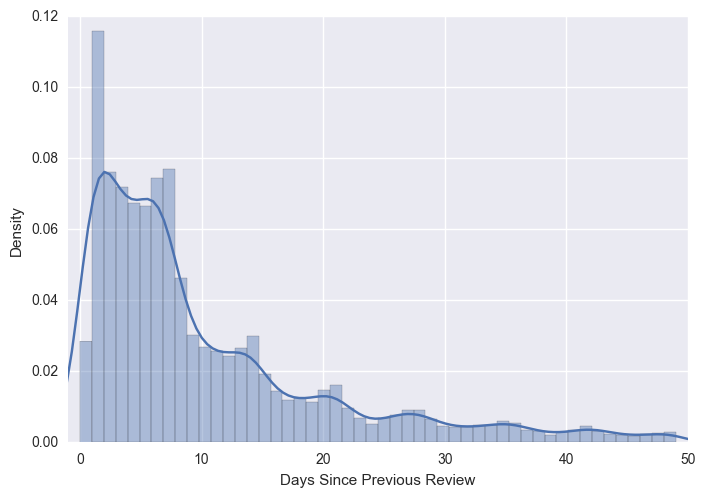

In [4]:
data = reviews.days_elapsed.dropna()
data = data[data<50]

sns.distplot(data, bins = 50)
plt.xlabel('Days Since Previous Review')
plt.ylabel('Density')
plt.xlim([-1,50])
plt.show()

I checked it out: [Julianne Escobedo Shepherd](http://pitchfork.com/staff/julianne-escobedo-shepard/) didn't publish anything on Pitchfork between writing a review for Ciara's [The Evolution](http://pitchfork.com/reviews/albums/9759-the-evolution/) in 2007 and Solange's [A Seat At The Table](http://pitchfork.com/reviews/albums/22482-a-seat-at-the-table/) last year. Besides that pretty nutty point, most reviews are published within a week or so of the author's previous review.

## Score and Best New Music Autocorrelations

So the key question: how does the score or best new music status of review $n$ correlate with that of $n+1$?

In [5]:
def autocorrfun(x, col, lag = 1):
    x_sort = x.sort_values(by = 'review_num')
    return x_sort[col].autocorr(lag)

autocorrelations = pd.DataFrame(
    index = pd.unique(reviews.author), 
    columns = ['score', 'best_new_music']
)

for i, rows in reviews.groupby('author'):
    if rows.shape[0] < 5:
        autocorrelations = autocorrelations.drop(i)
        continue
    
    for j in autocorrelations.columns:
        autocorrelations.loc[i, j] = autocorrfun(rows, j)

autocorrelations = autocorrelations.astype(float)        
autocorrelations.describe()

,score,best_new_music
count,219.00,1.24e+02
mean,-0.05,3.73e-03
std,0.25,1.36e-01
min,-0.96,-3.33e-01
25%,-0.18,-6.15e-02
50%,-0.03,-3.08e-02
75%,0.07,2.13e-02
max,0.70,4.79e-01


score: p = 0.00237133392457
best_new_music: p = 0.760200306934


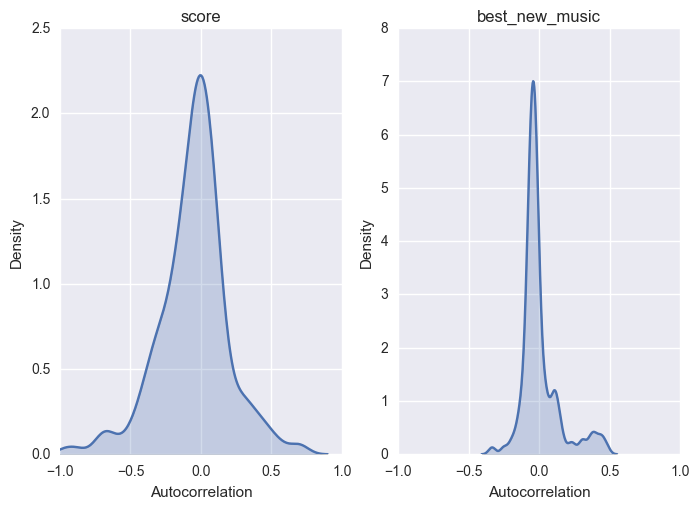

In [6]:
from scipy.stats import ttest_1samp

f, axs = plt.subplots(1,2)
for i, col in enumerate(autocorrelations.columns.values):
    h = axs[i]
    data = autocorrelations[col].dropna()
    
    p = ttest_1samp(data,0).pvalue
    print(col + ': p = ' + str(p))
    sns.kdeplot(data, ax = h, shade=True,gridsize=200, legend = False)
    h.set_xlim(np.array([-1,1]))
    h.set_title(col)
    h.set_xlabel('Autocorrelation')
    h.set_ylabel('Density')
    
plt.show()

In aggregate, there aren't systematically strong autocorrelations, especially in the base of best new music. Scores are slightly negatively autocorrelated, so high scoring reviews are likely to be followed by low scores, etc, but that difference isn't much to speak of.

These estimates are probably obscured by the majority of middle-range scores though. Only 10% of reviews lie below a score of 5.5, and only 10% above 8.2 (see [this notebook](https://github.com/nolanbconaway/pitchfork-data/blob/master/notebooks/review-score-exploration.ipynb)). Authors probably don't feel they need to compensate for reviews within that range. Scores outside that range are comparatively unusual, and so if there were autocorrelations we'd see them there.

In [7]:
def get_next_reviews(df):
    res = pd.DataFrame(index = None, columns = reviews.columns)
    for a, rows in df.groupby('author'):
        nums = rows.review_num+1
        idx = (reviews.author == a) & reviews.review_num.isin(nums)
        res = res.append(reviews.loc[idx])
    return res


score_split = dict(low = dict(), mid = dict(), high = dict())
for i in score_split.keys():
    
    if i=='low':
        idx = reviews.score<5.5
    elif i == 'mid':
        idx = (reviews.score<=8.2) & (reviews.score>=5.5)
    elif i=='high':
        idx = reviews.score>8.2
    
    score_split[i]['N'] = reviews.loc[idx]
    score_split[i]['N+1'] = get_next_reviews(score_split[i]['N'])     


high	 N mean= 8.70731434953	 N+1 mean=7.22078295912
mid	 N mean= 7.12214522215	 N+1 mean=7.02043789872
low	 N mean= 4.32439777641	 N+1 mean=6.7641509434


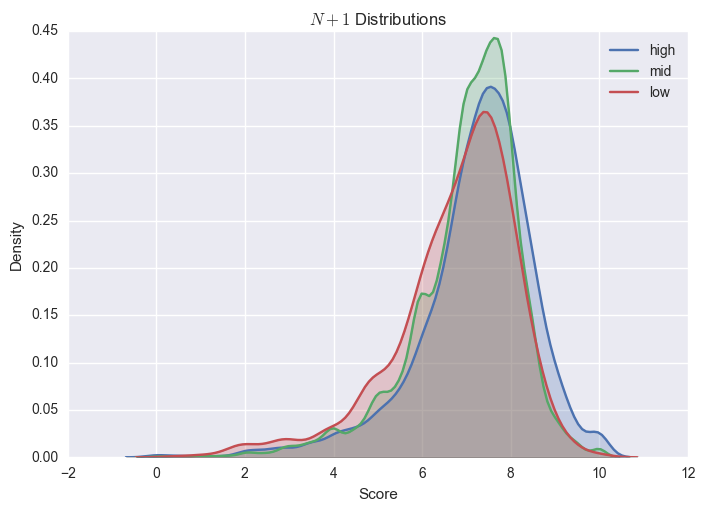

In [8]:
for i, k in enumerate(['high','mid','low']):
    data = score_split[k]['N+1']
    sns.kdeplot(data.score.dropna(), shade=True, label = k)
    
    m1 = score_split[k]['N+1'].score.mean()
    m0 = score_split[k]['N'].score.mean()
    
    print(k + '\t N mean= ' + str(m0) + '\t N+1 mean=' + str(m1))
    
# plt.axis([0,10,0,1.6])


plt.xlabel('Score')
plt.ylabel('Density')
plt.title('$N+1$ Distributions')
plt.show()

## Results

Obviously there is a huge amount of overlap in the distributions following low, mid, and high scoring reviews. The marginally negative autocorrelations observed earlier are probably from a slight decline (0.1) in scores at times $N$ and $N+1$ for mid-range reviews. 

**But**, on average, albums reviewed after a low scoring review are scored nearly 0.5 _worse_ than those after a high scoring review. That's a surprisingly strong difference given how tightly scores are distributed in general. A score difference 0.5 absolutely makes a difference with respect to how the album is received: a 7.8 is almost modal, but an 8.3 is often _best new music_. 

In the [paper](https://academic.oup.com/qje/article/131/3/1181/2590011/) I referenced at the top of this page, a main interest was in how borderline decisions (i.e., the pitch could be a strike or a ball) are made based on previous decisions. Here I haven't paid special attention to these borderline cases, but it's likely these effects make an even bigger difference for albums that could or could not be considered best new music.